In [1]:
# importar paquetes a ocupar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
import xgboost
import catboost
from sklearn.model_selection import train_test_split
import zipfile
import os
import gradio

In [2]:
# importar archivos csv# Abrir el archivo comprimido
with zipfile.ZipFile('datasets/teams/battlelog_teams.zip', 'r') as zip_ref:
    # Extraer el archivo CSV
    zip_ref.extractall('datasets/teams/')

crossBattlelog = pd.read_csv('datasets/teams/battlelog_teams.csv', index_col=0)

os.remove('datasets/teams/battlelog_teams.csv')

crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531208 entries, 0 to 531207
Data columns (total 63 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   battleTime                             531208 non-null  object 
 1   playertag                              531208 non-null  object 
 2   event.id                               531208 non-null  int64  
 3   event.mode                             531208 non-null  object 
 4   event.map                              531208 non-null  object 
 5   battle.mode                            531208 non-null  object 
 6   battle.type                            531208 non-null  object 
 7   battle.result                          531208 non-null  object 
 8   battle.duration                        531208 non-null  float64
 9   battle.trophyChange                    393833 non-null  float64
 10  battle.starPlayer.tag                  446999 non-null  

In [3]:
# importar archivos csv
brawlers = pd.read_csv('datasets/brawlers/brawlers_stats.csv', index_col=0)
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   starPowers      64 non-null     object 
 3   gadgets         64 non-null     object 
 4   Brawler         64 non-null     object 
 5   Health          64 non-null     float64
 6   Rarity          64 non-null     object 
 7   Class           64 non-null     object 
 8   Movement_Speed  64 non-null     object 
 9   Range           63 non-null     object 
 10  Reload          63 non-null     object 
 11  Speed_Num       64 non-null     int64  
 12  Range_Num       64 non-null     float64
 13  Reload_Num      63 non-null     float64
 14  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(10)
memory usage: 8.0+ KB


In [4]:
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)

In [5]:
brawler_wr_ur = pd.read_csv('datasets/teams/brawler_winrate_userate.csv', index_col=0)

In [6]:
# crear columna playerteam
for i in range(len(crossBattlelog)):
	if any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team1.player1.tag'], crossBattlelog.loc[i, 'battle.team1.player2.tag'], crossBattlelog.loc[i, 'battle.team1.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team1'
	elif any(crossBattlelog.loc[i, 'playertag'] == tag for tag in [crossBattlelog.loc[i, 'battle.team2.player1.tag'], crossBattlelog.loc[i, 'battle.team2.player2.tag'], crossBattlelog.loc[i, 'battle.team2.player3.tag']]):
		crossBattlelog.loc[i, 'player_team'] = 'team2'
	else:
		print("error in team assignation for id " + str(i))

crossBattlelog['player_team'].value_counts()

team1    267222
team2    263986
Name: player_team, dtype: int64

In [7]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['battle.result'] != 'draw'].reset_index(drop=True)

In [8]:
# crear columna winner_team
for i, result in enumerate(crossBattlelog['battle.result']):

	player_team = crossBattlelog.loc[i, 'player_team']
	
	if result == 'draw':
		crossBattlelog.loc[i, 'winner_team'] = 'draw'
	elif (player_team == 'team1' and result == 'victory') or (player_team == 'team2' and result == 'defeat'):
		crossBattlelog.loc[i, 'winner_team'] = 'team1'
	elif (player_team == 'team1' and result == 'defeat') or (player_team == 'team2' and result == 'victory'):
		crossBattlelog.loc[i, 'winner_team'] = 'team2'
	else:
		print("error in winner assignation for id " + str(i))

crossBattlelog['winner_team'].value_counts()

team1    267118
team2    260597
Name: winner_team, dtype: int64

In [9]:
#escoger columnas a ocupar
crossBattlelog = crossBattlelog[[	
	'event.mode'
	,'event.map'
	,'battle.type'
	,'battle.duration'
	,'battle.team1.player1.brawler.name'
	,'battle.team1.player1.brawler.power'
	,'battle.team1.player1.brawler.trophies'
	,'battle.team1.player2.brawler.name'
	,'battle.team1.player2.brawler.power'
	,'battle.team1.player2.brawler.trophies'
	,'battle.team1.player3.brawler.name'
	,'battle.team1.player3.brawler.power'
	,'battle.team1.player3.brawler.trophies'
	,'battle.team2.player1.brawler.name'
	,'battle.team2.player1.brawler.power'
	,'battle.team2.player1.brawler.trophies'
	,'battle.team2.player2.brawler.name'
	,'battle.team2.player2.brawler.power'
	,'battle.team2.player2.brawler.trophies'
	,'battle.team2.player3.brawler.name'
	,'battle.team2.player3.brawler.power'
	,'battle.team2.player3.brawler.trophies'
	,'winner_team'
]]

crossBattlelog

,event.mode,event.map,battle.type,battle.duration,battle.team1.player1.brawler.name,battle.team1.player1.brawler.power,battle.team1.player1.brawler.trophies,battle.team1.player2.brawler.name,battle.team1.player2.brawler.power,battle.team1.player2.brawler.trophies,battle.team1.player3.brawler.name,battle.team1.player3.brawler.power,battle.team1.player3.brawler.trophies,battle.team2.player1.brawler.name,battle.team2.player1.brawler.power,battle.team2.player1.brawler.trophies,battle.team2.player2.brawler.name,battle.team2.player2.brawler.power,battle.team2.player2.brawler.trophies,battle.team2.player3.brawler.name,battle.team2.player3.brawler.power,battle.team2.player3.brawler.trophies,winner_team
0,brawlBall,Sunny Soccer,ranked,67.0,TARA,7.0,274.0,EL PRIMO,9.0,489.0,MANDY,10.0,288.0,PENNY,8.0,354.0,BULL,7.0,354.0,JACKY,8.0,350.0,team1
1,hotZone,Dueling Beetles,soloRanked,118.0,MAX,10.0,13.0,BEA,11.0,13.0,LEON,11.0,13.0,DYNAMIKE,11.0,14.0,STU,11.0,14.0,OTIS,11.0,12.0,team1
2,hotZone,Dueling Beetles,soloRanked,125.0,MAX,10.0,13.0,BEA,11.0,13.0,LEON,11.0,13.0,DYNAMIKE,11.0,14.0,STU,11.0,14.0,OTIS,11.0,12.0,team2
3,hotZone,Dueling Beetles,soloRanked,143.0,MAX,10.0,13.0,BEA,11.0,13.0,LEON,11.0,13.0,DYNAMIKE,11.0,14.0,STU,11.0,14.0,OTIS,11.0,12.0,team1
4,heist,Bridge Too Far,soloRanked,71.0,MAX,11.0,14.0,PIPER,10.0,13.0,BROCK,11.0,12.0,COLT,11.0,14.0,BEA,10.0,12.0,MEG,11.0,13.0,team2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527710,gemGrab,Double Swoosh,ranked,90.0,CROW,11.0,817.0,PENNY,10.0,972.0,ASH,11.0,915.0,GENE,11.0,1116.0,BUSTER,10.0,1171.0,CHESTER,11.0,1083.0,team1
527711,hotZone,Quarter Pounder,ranked,91.0,BARLEY,10.0,813.0,STU,11.0,869.0,BEA,10.0,896.0,BIBI,11.0,852.0,CHESTER,11.0,752.0,GRAY,11.0,883.0,team2
527712,gemGrab,Double Swoosh,ranked,131.0,GENE,10.0,748.0,SURGE,10.0,1185.0,SPIKE,10.0,825.0,JESSIE,10.0,874.0,CROW,11.0,882.0,CHESTER,11.0,891.0,team2
527713,gemGrab,Double Swoosh,ranked,119.0,BO,11.0,820.0,LOLA,10.0,741.0,BROCK,10.0,649.0,GUS,10.0,942.0,BUSTER,11.0,319.0,CHESTER,11.0,1058.0,team2


In [ ]:
# crear columna winner
# def clean_winner(team):

# 	if team == 'team1':
# 		oteam = 'team2'
# 	else:
# 		oteam = 'team1'
	
# 	dfw = crossBattlelog[crossBattlelog['player_team'] == team].reset_index(drop = True)

# 	for i, winner_team in enumerate(dfw['winner_team']):
# 		if winner_team == team:
# 			winner = team
# 		else:
# 			winner = oteam
		
# 		dfw.loc[i, 'winner'] = winner

# 	dfw = dfw.drop('winner_team', axis=1)

# 	dfw = dfw.rename(columns={
# 		'battle.' + team + '.player1.brawler.name': 'battle.team1.player1.brawler.name'
# 		,'battle.' + team + '.player1.brawler.power': 'battle.team1.player1.brawler.power'
# 		,'battle.' + team + '.player1.brawler.trophies': 'battle.team1.player1.brawler.trophies'
# 		,'battle.' + team + '.player2.brawler.name': 'battle.team1.player2.brawler.name'
# 		,'battle.' + team + '.player2.brawler.power': 'battle.team1.player2.brawler.power'
# 		,'battle.' + team + '.player2.brawler.trophies': 'battle.team1.player2.brawler.trophies'
# 		,'battle.' + team + '.player3.brawler.name': 'battle.team1.player3.brawler.name'
# 		,'battle.' + team + '.player3.brawler.power': 'battle.team1.player3.brawler.power'
# 		,'battle.' + team + '.player3.brawler.trophies': 'battle.team1.player3.brawler.trophies'
# 		,'battle.' + oteam + '.player1.brawler.name': 'battle.team2.player1.brawler.name'
# 		,'battle.' + oteam + '.player1.brawler.power': 'battle.team2.player1.brawler.power'
# 		,'battle.' + oteam + '.player1.brawler.trophies': 'battle.team2.player1.brawler.trophies'
# 		,'battle.' + oteam + '.player2.brawler.name': 'battle.team2.player2.brawler.name'
# 		,'battle.' + oteam + '.player2.brawler.power': 'battle.team2.player2.brawler.power'
# 		,'battle.' + oteam + '.player2.brawler.trophies': 'battle.team2.player2.brawler.trophies'
# 		,'battle.' + oteam + '.player3.brawler.name': 'battle.team2.player3.brawler.name'
# 		,'battle.' + oteam + '.player3.brawler.power': 'battle.team2.player3.brawler.power'
# 		,'battle.' + oteam + '.player3.brawler.trophies': 'battle.team2.player3.brawler.trophies'
# 	})

# 	dfw = dfw[[	
# 		'event.mode'
# 		,'event.map'
# 		,'battle.type'
# 		,'battle.duration'
# 		,'battle.team1.player1.brawler.name'
# 		,'battle.team1.player1.brawler.power'
# 		,'battle.team1.player1.brawler.trophies'
# 		,'battle.team1.player2.brawler.name'
# 		,'battle.team1.player2.brawler.power'
# 		,'battle.team1.player2.brawler.trophies'
# 		,'battle.team1.player3.brawler.name'
# 		,'battle.team1.player3.brawler.power'
# 		,'battle.team1.player3.brawler.trophies'
# 		,'battle.team2.player1.brawler.name'
# 		,'battle.team2.player1.brawler.power'
# 		,'battle.team2.player1.brawler.trophies'
# 		,'battle.team2.player2.brawler.name'
# 		,'battle.team2.player2.brawler.power'
# 		,'battle.team2.player2.brawler.trophies'
# 		,'battle.team2.player3.brawler.name'
# 		,'battle.team2.player3.brawler.power'
# 		,'battle.team2.player3.brawler.trophies'
# 		,'winner'
# 	]]
	
# 	dfl = crossBattlelog[crossBattlelog['player_team'] == team].reset_index(drop = True)

# 	for i, winner_team in enumerate(dfl['winner_team']):
# 		if winner_team == oteam:
# 			winner = oteam
# 		else:
# 			winner = team
		
# 		dfl.loc[i, 'winner'] = winner

# 	dfl = dfl.drop('winner_team', axis=1)

# 	dfl = dfl.rename(columns={
# 		'battle.' + oteam + '.player1.brawler.name': 'battle.team1.player1.brawler.name'
# 		,'battle.' + oteam + '.player1.brawler.power': 'battle.team1.player1.brawler.power'
# 		,'battle.' + oteam + '.player1.brawler.trophies': 'battle.team1.player1.brawler.trophies'
# 		,'battle.' + oteam + '.player2.brawler.name': 'battle.team1.player2.brawler.name'
# 		,'battle.' + oteam + '.player2.brawler.power': 'battle.team1.player2.brawler.power'
# 		,'battle.' + oteam + '.player2.brawler.trophies': 'battle.team1.player2.brawler.trophies'
# 		,'battle.' + oteam + '.player3.brawler.name': 'battle.team1.player3.brawler.name'
# 		,'battle.' + oteam + '.player3.brawler.power': 'battle.team1.player3.brawler.power'
# 		,'battle.' + oteam + '.player3.brawler.trophies': 'battle.team1.player3.brawler.trophies'
# 		,'battle.' + team + '.player1.brawler.name': 'battle.team2.player1.brawler.name'
# 		,'battle.' + team + '.player1.brawler.power': 'battle.team2.player1.brawler.power'
# 		,'battle.' + team + '.player1.brawler.trophies': 'battle.team2.player1.brawler.trophies'
# 		,'battle.' + team + '.player2.brawler.name': 'battle.team2.player2.brawler.name'
# 		,'battle.' + team + '.player2.brawler.power': 'battle.team2.player2.brawler.power'
# 		,'battle.' + team + '.player2.brawler.trophies': 'battle.team2.player2.brawler.trophies'
# 		,'battle.' + team + '.player3.brawler.name': 'battle.team2.player3.brawler.name'
# 		,'battle.' + team + '.player3.brawler.power': 'battle.team2.player3.brawler.power'
# 		,'battle.' + team + '.player3.brawler.trophies': 'battle.team2.player3.brawler.trophies'
# 	})

# 	dfl = dfl[[	
# 		'event.mode'
# 		,'event.map'
# 		,'battle.type'
# 		,'battle.duration'
# 		,'battle.team1.player1.brawler.name'
# 		,'battle.team1.player1.brawler.power'
# 		,'battle.team1.player1.brawler.trophies'
# 		,'battle.team1.player2.brawler.name'
# 		,'battle.team1.player2.brawler.power'
# 		,'battle.team1.player2.brawler.trophies'
# 		,'battle.team1.player3.brawler.name'
# 		,'battle.team1.player3.brawler.power'
# 		,'battle.team1.player3.brawler.trophies'
# 		,'battle.team2.player1.brawler.name'
# 		,'battle.team2.player1.brawler.power'
# 		,'battle.team2.player1.brawler.trophies'
# 		,'battle.team2.player2.brawler.name'
# 		,'battle.team2.player2.brawler.power'
# 		,'battle.team2.player2.brawler.trophies'
# 		,'battle.team2.player3.brawler.name'
# 		,'battle.team2.player3.brawler.power'
# 		,'battle.team2.player3.brawler.trophies'
# 		,'winner'
# 	]]

# 	return pd.concat([dfw, dfl], ignore_index=True)

# team1 = clean_winner('team1')
# team2 = clean_winner('team2')

# battlelogProcess = pd.concat([team1, team2], ignore_index=True).reset_index(drop = True)
# battlelogProcess.info()

In [10]:
# merge brawler stats
battlelogFinal = crossBattlelog

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

battlelogFinal = add_brawlers(battlelogFinal, 'battle.team1.player1.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team1.player2.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team1.player3.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team2.player1.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team2.player2.brawler.')
battlelogFinal = add_brawlers(battlelogFinal, 'battle.team2.player3.brawler.')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527715 entries, 0 to 527714
Data columns (total 83 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   event.mode                                   527715 non-null  object 
 1   event.map                                    527715 non-null  object 
 2   battle.type                                  527715 non-null  object 
 3   battle.duration                              527715 non-null  float64
 4   battle.team1.player1.brawler.name            527715 non-null  object 
 5   battle.team1.player1.brawler.power           527715 non-null  float64
 6   battle.team1.player1.brawler.trophies        527715 non-null  float64
 7   battle.team1.player2.brawler.name            527715 non-null  object 
 8   battle.team1.player2.brawler.power           527715 non-null  float64
 9   battle.team1.player2.brawler.trophies        527715 non-nul

In [11]:
# merge map data
battlelogFinal = battlelogFinal.merge(barrierList, how='inner', on='event.map')
battlelogFinal = battlelogFinal.merge(bushList, how='inner', on='event.map')
battlelogFinal = battlelogFinal.merge(waterList, how='left', on='event.map')
battlelogFinal['waterProp'] = battlelogFinal['waterProp'].fillna(0)
battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527715 entries, 0 to 527714
Data columns (total 88 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   event.mode                                   527715 non-null  object 
 1   event.map                                    527715 non-null  object 
 2   battle.type                                  527715 non-null  object 
 3   battle.duration                              527715 non-null  float64
 4   battle.team1.player1.brawler.name            527715 non-null  object 
 5   battle.team1.player1.brawler.power           527715 non-null  float64
 6   battle.team1.player1.brawler.trophies        527715 non-null  float64
 7   battle.team1.player2.brawler.name            527715 non-null  object 
 8   battle.team1.player2.brawler.power           527715 non-null  float64
 9   battle.team1.player2.brawler.trophies        527715 non-nul

In [12]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event.mode', 'event.map', 'winrate', 'userate', 'percentile_quadrant']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event.mode', 'event.map']
		,right_on=[prefix + 'brawlername', prefix + 'event.mode', prefix + 'event.map']
		,how='left'
		,suffixes=('','_w'))
	return df

battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team1.player1.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team1.player2.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team1.player3.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team2.player1.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team2.player2.brawler.')
battlelogFinal = add_wr_ur(battlelogFinal, 'battle.team2.player3.brawler.')

battlelogFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527715 entries, 0 to 527714
Columns: 124 entries, event.mode to battle.team2.player3.brawler.percentile_quadrant
dtypes: float64(45), int64(9), object(70)
memory usage: 503.3+ MB


In [14]:
# crear columna battle brawlers
# def create_list_name(row, column):
#     return [str(row['battle.player1.brawler.' + column]), str(row['battle.player2.brawler.' + column]), str(row['battle.player3.brawler.' + column])]

# battlelogFinal['battle.brawlers'] = battlelogFinal.apply(lambda row: create_list_name(row, 'name'), axis=1)
# battlelogFinal['battle.brawlers'] = [str(sorted(roles)) for roles in battlelogFinal['battle.brawlers']]

# battlelogFinal['battle.brawlers']

In [13]:
plt.style.use('ggplot')

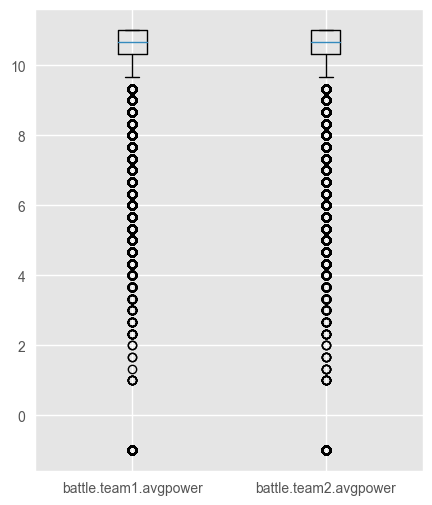

In [14]:
# crear columna avg power
def create_avg(row, team, column):
    return (row['battle.' + team + '.player1.brawler.'+ column] + row['battle.' + team + '.player2.brawler.'+ column] + row['battle.' + team + '.player3.brawler.'+ column]) / 3

def create_boxplots(df, col1, col2):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 6)
    ax.boxplot([df[col1], df[col2]])
    ax.set_xticklabels([col1, col2])
    plt.show()

battlelogFinal['battle.team1.avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team1.avgpower'].isna() == False]
battlelogFinal['battle.team2.avgpower'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'power'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team2.avgpower'].isna() == False]

create_boxplots(battlelogFinal, 'battle.team1.avgpower', 'battle.team2.avgpower')

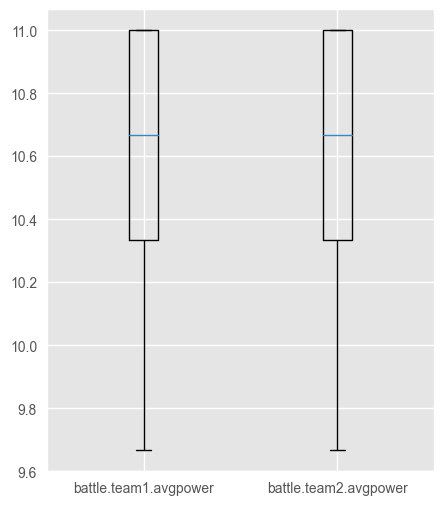

In [15]:
# subset avg power
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avgpower'] > 9.5) & (battlelogFinal['battle.team2.avgpower'] > 9.5)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avgpower', 'battle.team2.avgpower')

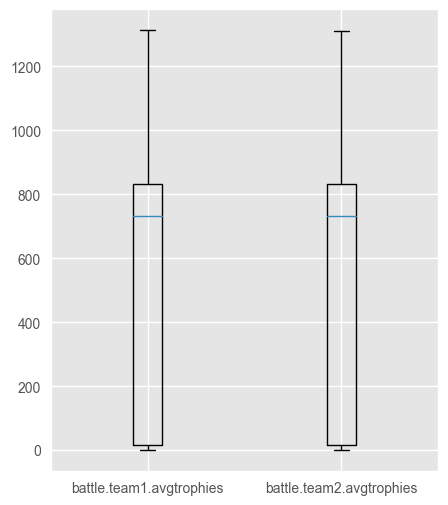

In [16]:
# crear columna avg trophies
battlelogFinal['battle.team1.avgtrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'trophies'), axis=1)
battlelogFinal['battle.team2.avgtrophies'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'trophies'), axis=1)

create_boxplots(battlelogFinal, 'battle.team1.avgtrophies', 'battle.team2.avgtrophies')

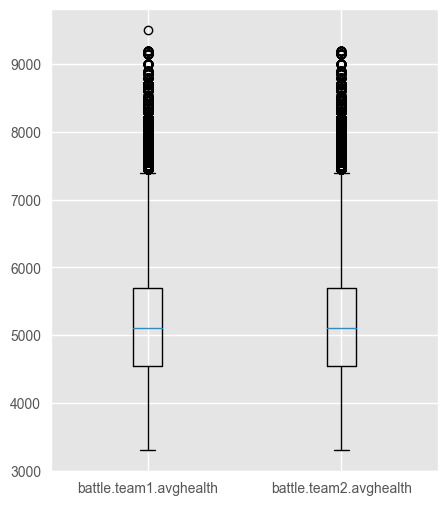

In [17]:
# crear columna avg health
battlelogFinal['battle.team1.avghealth'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'Health'), axis=1).reset_index(drop=True)
battlelogFinal['battle.team2.avghealth'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'Health'), axis=1).reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avghealth', 'battle.team2.avghealth')

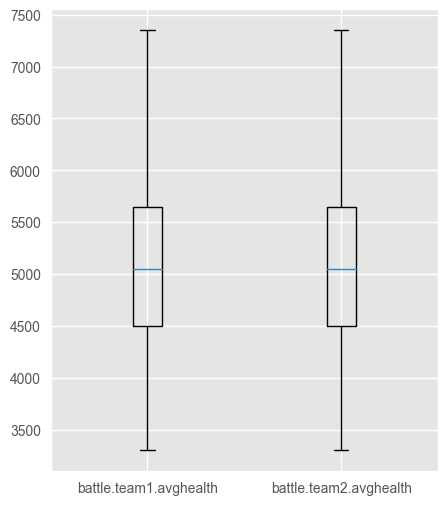

In [18]:
# subset avg health
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avghealth'] < 7400) & (battlelogFinal['battle.team2.avghealth'] < 7400)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avghealth', 'battle.team2.avghealth')

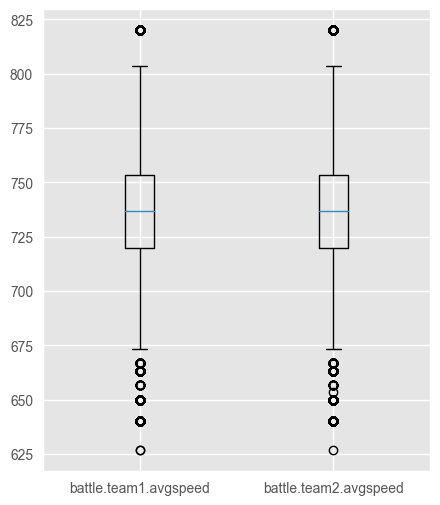

In [19]:
# crear columna avg speed
battlelogFinal['battle.team1.avgspeed'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'Speed_Num'), axis=1)
battlelogFinal['battle.team2.avgspeed'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'Speed_Num'), axis=1)

create_boxplots(battlelogFinal, 'battle.team1.avgspeed', 'battle.team2.avgspeed')

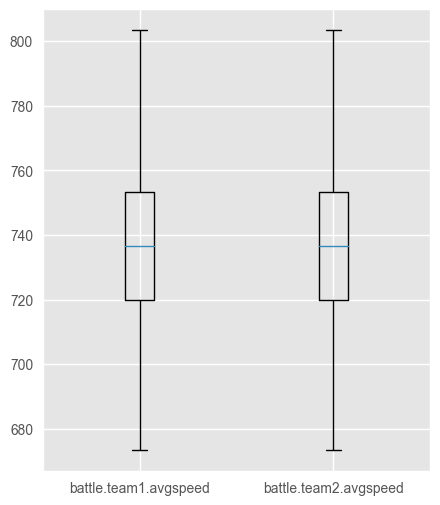

In [20]:
# subset avg speed
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avgspeed'] >= 670) & (battlelogFinal['battle.team1.avgspeed'] <= 810) & (battlelogFinal['battle.team2.avgspeed'] >= 670) & (battlelogFinal['battle.team2.avgspeed'] <= 810)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avgspeed', 'battle.team2.avgspeed')

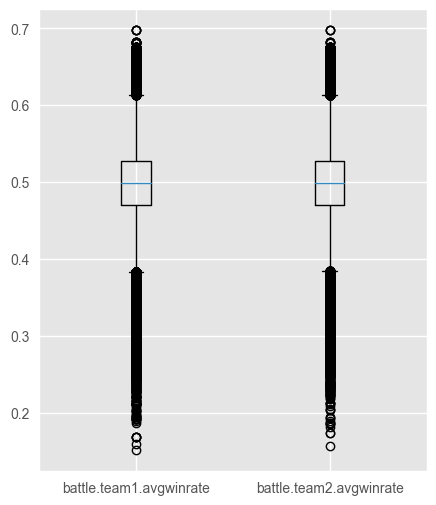

In [21]:
# crear columna avg winrate
battlelogFinal['battle.team1.avgwinrate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'winrate'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team1.avgwinrate'].isna() == False]
battlelogFinal['battle.team2.avgwinrate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'winrate'), axis=1)
battlelogFinal = battlelogFinal[battlelogFinal['battle.team2.avgwinrate'].isna() == False]

create_boxplots(battlelogFinal, 'battle.team1.avgwinrate', 'battle.team2.avgwinrate')

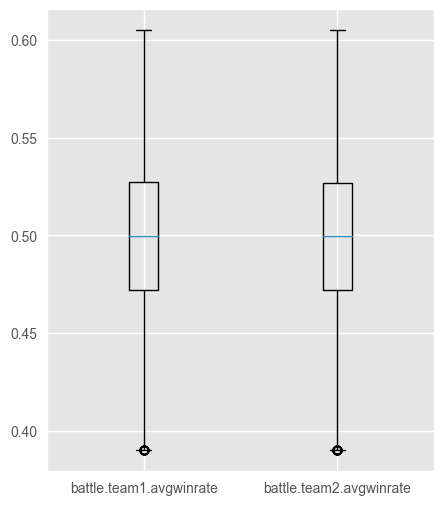

In [22]:
# subset avg winrate
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avgwinrate'] >= 0.39) & (battlelogFinal['battle.team1.avgwinrate'] <= 0.605) & (battlelogFinal['battle.team2.avgwinrate'] >= 0.39) & (battlelogFinal['battle.team2.avgwinrate'] <= 0.605)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avgwinrate', 'battle.team2.avgwinrate')

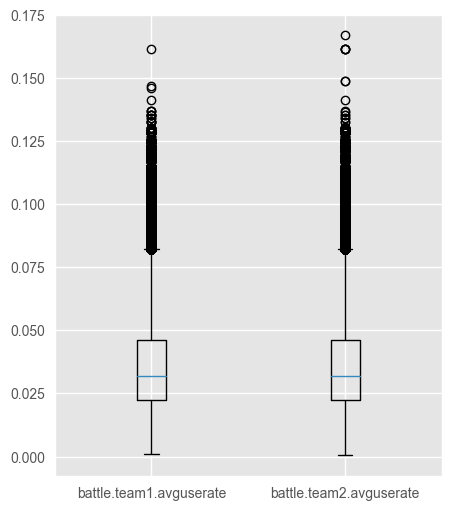

In [23]:
# crear columna avg userate
battlelogFinal['battle.team1.avguserate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team1', 'userate'), axis=1)
battlelogFinal['battle.team2.avguserate'] = battlelogFinal.apply(lambda row: create_avg(row, 'team2', 'userate'), axis=1)

create_boxplots(battlelogFinal, 'battle.team1.avguserate', 'battle.team2.avguserate')

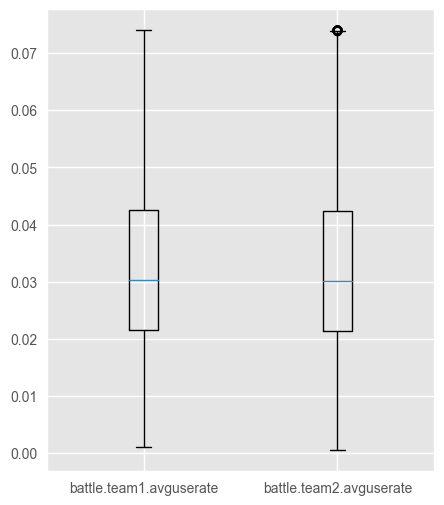

In [24]:
# subset avg userate
battlelogFinal = battlelogFinal[(battlelogFinal['battle.team1.avguserate'] <= 0.074) & (battlelogFinal['battle.team2.avguserate'] <= 0.074)].reset_index(drop=True)

create_boxplots(battlelogFinal, 'battle.team1.avguserate', 'battle.team2.avguserate')

In [25]:
battlelogFinal.shape

(372807, 136)

In [27]:
battlelogFinal.head()

,event.mode,event.map,battle.type,battle.duration,battle.team1.player1.brawler.name,battle.team1.player1.brawler.power,battle.team1.player1.brawler.trophies,battle.team1.player2.brawler.name,battle.team1.player2.brawler.power,battle.team1.player2.brawler.trophies,battle.team1.player3.brawler.name,battle.team1.player3.brawler.power,battle.team1.player3.brawler.trophies,battle.team2.player1.brawler.name,battle.team2.player1.brawler.power,battle.team2.player1.brawler.trophies,battle.team2.player2.brawler.name,battle.team2.player2.brawler.power,battle.team2.player2.brawler.trophies,battle.team2.player3.brawler.name,battle.team2.player3.brawler.power,battle.team2.player3.brawler.trophies,winner_team,battle.team1.player1.brawler.Health,battle.team1.player1.brawler.Rarity,battle.team1.player1.brawler.Class,battle.team1.player1.brawler.Movement_Speed,battle.team1.player1.brawler.Range,battle.team1.player1.brawler.Reload,battle.team1.player1.brawler.Speed_Num,battle.team1.player1.brawler.Range_Num,battle.team1.player1.brawler.Reload_Num,battle.team1.player1.brawler.Role,battle.team1.player2.brawler.Health,battle.team1.player2.brawler.Rarity,battle.team1.player2.brawler.Class,battle.team1.player2.brawler.Movement_Speed,battle.team1.player2.brawler.Range,battle.team1.player2.brawler.Reload,battle.team1.player2.brawler.Speed_Num,battle.team1.player2.brawler.Range_Num,battle.team1.player2.brawler.Reload_Num,battle.team1.player2.brawler.Role,battle.team1.player3.brawler.Health,battle.team1.player3.brawler.Rarity,battle.team1.player3.brawler.Class,battle.team1.player3.brawler.Movement_Speed,battle.team1.player3.brawler.Range,battle.team1.player3.brawler.Reload,battle.team1.player3.brawler.Speed_Num,battle.team1.player3.brawler.Range_Num,battle.team1.player3.brawler.Reload_Num,battle.team1.player3.brawler.Role,battle.team2.player1.brawler.Health,battle.team2.player1.brawler.Rarity,battle.team2.player1.brawler.Class,battle.team2.player1.brawler.Movement_Speed,battle.team2.player1.brawler.Range,battle.team2.player1.brawler.Reload,battle.team2.player1.brawler.Speed_Num,battle.team2.player1.brawler.Range_Num,battle.team2.player1.brawler.Reload_Num,battle.team2.player1.brawler.Role,battle.team2.player2.brawler.Health,battle.team2.player2.brawler.Rarity,battle.team2.player2.brawler.Class,battle.team2.player2.brawler.Movement_Speed,battle.team2.player2.brawler.Range,battle.team2.player2.brawler.Reload,battle.team2.player2.brawler.Speed_Num,battle.team2.player2.brawler.Range_Num,battle.team2.player2.brawler.Reload_Num,battle.team2.player2.brawler.Role,battle.team2.player3.brawler.Health,battle.team2.player3.brawler.Rarity,battle.team2.player3.brawler.Class,battle.team2.player3.brawler.Movement_Speed,battle.team2.player3.brawler.Range,battle.team2.player3.brawler.Reload,battle.team2.player3.brawler.Speed_Num,battle.team2.player3.brawler.Range_Num,battle.team2.player3.brawler.Reload_Num,battle.team2.player3.brawler.Role,barriers,barriers_center,bushes,bushes_center,waterProp,battle.team1.player1.brawler.brawlername,battle.team1.player1.brawler.event.mode,battle.team1.player1.brawler.event.map,battle.team1.player1.brawler.winrate,battle.team1.player1.brawler.userate,battle.team1.player1.brawler.percentile_quadrant,battle.team1.player2.brawler.brawlername,battle.team1.player2.brawler.event.mode,battle.team1.player2.brawler.event.map,battle.team1.player2.brawler.winrate,battle.team1.player2.brawler.userate,battle.team1.player2.brawler.percentile_quadrant,battle.team1.player3.brawler.brawlername,battle.team1.player3.brawler.event.mode,battle.team1.player3.brawler.event.map,battle.team1.player3.brawler.winrate,battle.team1.player3.brawler.userate,battle.team1.player3.brawler.percentile_quadrant,battle.team2.player1.brawler.brawlername,battle.team2.player1.brawler.event.mode,battle.team2.player1.brawler.event.map,battle.team2.player1.brawler.winrate,battle.team2.player1.brawler.userate,battle.team2.player1.brawler.percentile_quadrant,battle.team2.player2.bra

In [29]:
# definición final de columnas
battlelog = battlelogFinal[[                             
'winner_team'
,'barriers'
,'barriers_center'
,'bushes'
,'bushes_center'
,'waterProp'
,'battle.team1.avgpower'
,'battle.team1.avgtrophies'
,'battle.team1.avghealth'
,'battle.team1.avgspeed'
,'battle.team1.avgwinrate'
,'battle.team1.avguserate'
,'battle.team1.player1.brawler.name'
,'battle.team1.player1.brawler.Class'
,'battle.team1.player1.brawler.Role'
,'battle.team1.player2.brawler.name'
,'battle.team1.player2.brawler.Class'
,'battle.team1.player2.brawler.Role'
,'battle.team1.player3.brawler.name'
,'battle.team1.player3.brawler.Class'
,'battle.team1.player3.brawler.Role'
,'battle.team2.avgpower'
,'battle.team2.avgtrophies'
,'battle.team2.avghealth'
,'battle.team2.avgspeed'
,'battle.team2.avgwinrate'
,'battle.team2.avguserate'
,'battle.team2.player1.brawler.name'
,'battle.team2.player1.brawler.Class'
,'battle.team2.player1.brawler.Role'
,'battle.team2.player2.brawler.name'
,'battle.team2.player2.brawler.Class'
,'battle.team2.player2.brawler.Role'
,'battle.team2.player3.brawler.name'
,'battle.team2.player3.brawler.Class'
,'battle.team2.player3.brawler.Role'
]]

battlelog.head()

,winner_team,barriers,barriers_center,bushes,bushes_center,waterProp,battle.team1.avgpower,battle.team1.avgtrophies,battle.team1.avghealth,battle.team1.avgspeed,battle.team1.avgwinrate,battle.team1.avguserate,battle.team1.player1.brawler.name,battle.team1.player1.brawler.Class,battle.team1.player1.brawler.Role,battle.team1.player2.brawler.name,battle.team1.player2.brawler.Class,battle.team1.player2.brawler.Role,battle.team1.player3.brawler.name,battle.team1.player3.brawler.Class,battle.team1.player3.brawler.Role,battle.team2.avgpower,battle.team2.avgtrophies,battle.team2.avghealth,battle.team2.avgspeed,battle.team2.avgwinrate,battle.team2.avguserate,battle.team2.player1.brawler.name,battle.team2.player1.brawler.Class,battle.team2.player1.brawler.Role,battle.team2.player2.brawler.name,battle.team2.player2.brawler.Class,battle.team2.player2.brawler.Role,battle.team2.player3.brawler.name,battle.team2.player3.brawler.Class,battle.team2.player3.brawler.Role
0,team1,71,26,78,22,0.0,10.333333,768.333333,4600.0,753.333333,0.474909,0.033764,MORTIS,Assassin,assassin,BARLEY,Damage Dealer,thrower,SPROUT,Support,thrower,10.333333,772.000000,5300.0,786.666667,0.429632,0.048705,TICK,Damage Dealer,thrower,BIBI,Damage Dealer,area control,MORTIS,Assassin,assassin
1,team2,71,26,78,22,0.0,10.333333,781.000000,5500.0,786.666667,0.478654,0.047080,MAX,Support,assassin,MORTIS,Assassin,assassin,NITA,Damage Dealer,area control,10.333333,789.666667,4900.0,753.333333,0.479249,0.041889,MORTIS,Assassin,assassin,SPIKE,Damage Dealer,ranged dps,SQUEAK,Damage Dealer,area control
2,team2,71,26,78,22,0.0,10.333333,844.000000,6100.0,736.666667,0.525018,0.020947,BARLEY,Damage Dealer,thrower,BUZZ,Assassin,close quarters,ASH,Tank,tank,11.000000,1113.333333,5350.0,736.666667,0.511228,0.017964,GRAY,Support,sniper,BEA,Damage Dealer,sniper,BULL,Tank,close quarters
3,team1,71,26,78,22,0.0,11.000000,1109.333333,5350.0,736.666667,0.511228,0.017964,GRAY,Support,sniper,BEA,Damage Dealer,sniper,BULL,Tank,close quarters,10.666667,799.666667,4400.0,753.333333,0.470646,0.014540,TARA,Damage Dealer,area control,BEA,Damage Dealer,sniper,LEON,Assassin,assassin
4,team1,71,26,78,22,0.0,11.000000,1105.333333,5350.0,736.666667,0.511228,0.017964,GRAY,Support,sniper,BEA,Damage Dealer,sniper,BULL,Tank,close quarters,11.000000,868.000000,5550.0,736.666667,0.521827,0.021338,STU,Assassin,assassin,LOU,Hybrid,area control,JACKY,Tank,tank


In [45]:
# cambiar working directory
print(os.getcwd())
os.chdir('machine_learning')
print(os.getcwd())

c:\Users\alniquia\OneDrive - Telefonica\Documents\Projects\BrawlStars_Model
c:\Users\alniquia\OneDrive - Telefonica\Documents\Projects\BrawlStars_Model\machine_learning


In [30]:
# generar set de testing y training
seed=14683

train, test = train_test_split(battlelog, test_size = 0.5, random_state=seed, stratify=battlelog['winner_team'])

train.shape

(186403, 36)

In [31]:
# setup model
session_1 = setup(
	data = train,
	target = 'winner_team',
	fix_imbalance = True,
    feature_selection= True,
	remove_outliers=True,
	log_experiment = True,
    use_gpu=False)

,Description,Value
0,session_id,8019
1,Target,winner_team
2,Target Type,Binary
3,Label Encoded,"team1: 0, team2: 1"
4,Original Data,"(186403, 36)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
#comparación de modelos
model = compare_models(include=['rf','gbc','lightgbm','ada','catboost','xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6440,0.7095,0.6398,0.6437,0.6417,0.2880,0.2881,72.8710
lightgbm,Light Gradient Boosting Machine,0.6390,0.7043,0.6301,0.6399,0.6350,0.2780,0.2780,24.6400
xgboost,Extreme Gradient Boosting,0.6360,0.6993,0.6312,0.6357,0.6334,0.2719,0.2720,129.2650
rf,Random Forest Classifier,0.6353,0.6840,0.6269,0.6360,0.6314,0.2705,0.2706,71.4090
gbc,Gradient Boosting Classifier,0.6348,0.6985,0.6274,0.6352,0.6313,0.2696,0.2697,111.1720
ada,Ada Boost Classifier,0.6244,0.6853,0.6239,0.6229,0.6234,0.2488,0.2489,40.0630


In [33]:
#try model blender

# example:
# train a few models
# lr = create_model('lr')
# dt = create_model('dt')
# knn = create_model('knn')

# blend models
# blender = blend_models([lr, dt, knn])
# blender_tuned = tune_model(blender, optimize = 'F1')

In [34]:
# tunear el mejor modelo
model_tuned = tune_model(model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6398,0.7078,0.6411,0.6379,0.6395,0.2796,0.2796
1,0.6405,0.7036,0.6366,0.6401,0.6383,0.2810,0.2810
2,0.6394,0.7056,0.6314,0.6401,0.6357,0.2788,0.2788
3,0.6442,0.7095,0.6406,0.6437,0.6422,0.2885,0.2885
4,0.6394,0.7031,0.6382,0.6382,0.6382,0.2788,0.2788
5,0.6432,0.7048,0.6426,0.6417,0.6422,0.2864,0.2864
6,0.6453,0.7078,0.6465,0.6433,0.6449,0.2906,0.2906
7,0.6431,0.7077,0.6370,0.6432,0.6401,0.2861,0.2861
8,0.6369,0.7025,0.6302,0.6371,0.6336,0.2737,0.2737


In [35]:
# compare hyperparameters
print(model)

print(model_tuned)

In [36]:
# interpret model
# interpret_model(model_tuned)

In [37]:
plot_model(model_tuned, plot='confusion_matrix', save=True)
plot_model(model_tuned, plot='feature', save=True)
plot_model(model_tuned, plot='calibration', save=True)

'Confusion Matrix.png'

In [42]:
# finalizar modelo
model_finalized = finalize_model(model_tuned)
predictions = predict_model(model_finalized, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0,0.7105,0,0,0,0,0


In [ ]:
# create_app(model_finalized)

In [43]:
save_model(model_finalized, 'models/catboost_try2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='winner_team', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                 ('feature_select',
                  Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                     n_jobs=-1,
                                                     random_state=8019,
                    

In [44]:
predictions.to_csv('datasets/predictions/predictions_lc.csv')